All code for the first batch of experiments. Details about each and affiliated output file are within each experiment.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np

In [2]:
import pandas as pd

In [3]:
from pathlib import Path
from sklearn import metrics
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

from datetime import datetime
import cv2

In [4]:
import matplotlib.pyplot as plt 

In [5]:
PATH = Path("/data2/yinterian/recology")
#list(PATH.iterdir())

In [6]:
path = list((PATH/"stretch_imgs").iterdir())[2]
path.suffix == ".jpg"

True

In [7]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

## Random transforms

In [8]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    r_pix = 8
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x):
    r, c,*_ = x.shape
    r_pix = 8
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

## Dataset

In [9]:
def norm_for_imageNet(img):
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (img - imagenet_stats[0])/imagenet_stats[1] 

In [10]:
class RecologyDataset(Dataset):
    def __init__(self, df, transform=False):
        self.path_to_images = resize_path = PATH/"imgs_250_333"
        self.transform = transform
        self.df = df
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = self.path_to_images/str(row["image_name"])
        y = row["labels"]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transform:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            x = random_crop(x)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
        else:
            x = center_crop(x)
        x = norm_for_imageNet(x)
        return np.rollaxis(x, 2), np.array(y)

In [11]:
train = pd.read_pickle(PATH/"recology_train_30k_1000.pkl")
valid = pd.read_pickle(PATH/"recology_valid_30k_1000.pkl")

In [12]:
train.head()

,image_name,tags,labels
0,439_75-79Pearl(3).jpg,cart plastic_bag bagged_items plastic_rigid_to...,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,352GrantAveCafedelaPresseLANDFILL(3).jpg,plastic_bag bagged_items food_scraps food_resi...,"[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ..."
2,2301ChestnutSt.LuckyBrandLANDFILL(6).jpg,plastic_bag bagged_items cardboard_clean paper...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1064_DIVISADERO_STREET_COMPOST(4).jpg,food_scraps paper_flat_soiled plastic_film_soi...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,1MarketPlazaOrganics#794(5).jpg,paper_napkin_soiled paper_cup plastic_film_soi...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."


In [13]:
train_ds = RecologyDataset(train, transform=True)
valid_ds = RecologyDataset(valid)

In [14]:
x, y = train_ds[0]

In [15]:
x.shape

(3, 234, 311)

In [16]:
x, y = valid_ds[0]

In [17]:
x.shape, y.shape

((3, 234, 311), (34,))

In [18]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size,  shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [19]:
y.shape

(34,)

## Model

In [20]:
# Model 2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.freeze()
        layers = list(self.resnet.children())[:8]
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:6], layers[6:]]])
        self.groups.append(nn.Linear(512, 34))

    def forward(self, x):
        for group in self.groups[:2]:
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[2](x)
        return x
    
    def freeze(self):
        for param in self.resnet.parameters():
            param.requires_grad = False
    
    def unfreeze(self,  group_idx:int):
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x,'requires_grad'), group.parameters())
        for p in parameters: 
            p.requires_grad = True

In [21]:
model = Net().cuda()

## Metrics

In [21]:
def ave_auc(probs, ys):
    probs = np.vstack(probs)
    ys = np.vstack(ys)
    aucs = [metrics.roc_auc_score(ys[:,i], probs[:,i]) for i in range(probs.shape[1])
            if ys[:,i].sum() >0]
    return np.mean(aucs)

In [22]:
def val_metric(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    probs = []
    ys = []
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().long()
        out = model(x)
        probs.append(out.detach().cpu().numpy())
        ys.append(y.cpu().numpy())
        loss = F.binary_cross_entropy_with_logits(out, y.float())
        sum_loss += batch*(loss.item())
        total += batch
    probs = np.vstack(probs)
    ys = np.vstack(ys)
    auc = ave_auc(probs, ys)
    return sum_loss/total, auc

In [23]:
def save_model(m, p): torch.save(m.state_dict(), p)

In [24]:
val_metric(model, valid_dl)

NameError: name 'model' is not defined

## Training 

In [25]:
def train(model, train_dl, valid_dl, lr, epochs=1):
    optim = get_optimizer(model, lr = lr, wd =0)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()     
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss %.3f" %(sum_loss/total))
        val_metric(model, valid_dl)
    return sum_loss/total

In [26]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

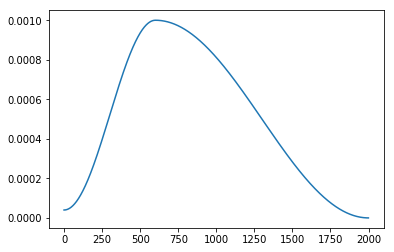

In [27]:
N = 2000
lr = get_cosine_triangular_lr(0.001, N)
plt.plot(list(range(N)), lr)
plt.show()

In [28]:
#data = {"lr": lr, "iter": list(range(iter))}
#df = pd.DataFrame(data) 
#df.to_csv("learning_rate_scheduler.csv")

In [29]:
def diff_lr(lr, alpha=1/3):
    return [lr*alpha**i for i in range(2,-1,-1)]

def create_optimizer(model, lr_0):
    param_groups = [list(model.groups[i].parameters()) for i in range(3)]
    params = [{'params':p, 'lr': lr} for p,lr in zip(param_groups, diff_lr(lr_0))]
    return optim.Adam(params)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [30]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs = 5):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_auc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            if idx == int(0.1*iterations):
                model.unfreeze(1)
                print(idx, "unfreezing 1")
            if idx == int(0.2*iterations):
                model.unfreeze(0)
                print(idx, "unfreezing 0")
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_auc = val_metric(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_auc %.3f \n" % 
              (train_loss, val_loss, val_auc))
        if val_auc > prev_val_auc:
            prev_val_auc = val_auc
            path = "{0}/models/model_1000_resnet34_auc_1_{1:.0f}.pth".format(PATH, 100*val_auc) 
            save_model(model, path)
            print(path)
    return sum_loss/total

## Learning rate finder -- new version

In [31]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    prev_loss = 0
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append((prev_loss + loss.item())/2)
            prev_loss = loss.item()
            ind +=1
            
    load_model(model, str(p))
    return lrs[1:], losses[1:]

In [389]:
model = Net().cuda()

In [390]:
lrs, losses = LR_range_finder(model, train_dl, lr_high=0.001)

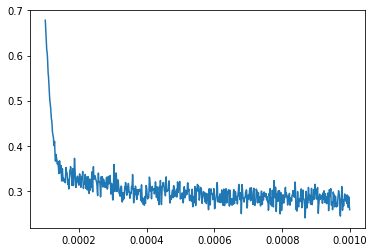

In [392]:
plt.plot(lrs, losses)
plt.show()

In [32]:
def save_model(m, p): 
    torch.save(m.state_dict(), p)

In [58]:
def train_one_model(i, model):
    train_triangular_policy(model, train_dl, valid_dl, epochs=1, max_lr=0.0004)
    model.unfreeze(1)
    name = "models/model_1000_resnet34_" + str(i) +  "_0" + ".pth"
    path = PATH/name
    train_triangular_policy(model, train_dl, valid_dl, epochs=5, max_lr=0.0004)
    save_model(model, path)
    print(path)
    model.unfreeze(0)
    train_triangular_policy(model, train_dl, valid_dl, epochs=5, max_lr=0.0004)
    name = "models/model_1000_resnet34_" + str(i) +  "_2" + ".pth"
    path = PATH/name
    save_model(model, path)
    print(path)

## Run Training 

In [59]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.002, epochs = 8)

684 unfreezing 1
train_loss 0.320 val_loss 0.287 val_auc 0.779 

/data2/yinterian/recology/models/model_1000_resnet34_auc_1_78.pth
1368 unfreezing 0
train_loss 0.271 val_loss 0.291 val_auc 0.781 

/data2/yinterian/recology/models/model_1000_resnet34_auc_1_78.pth
train_loss 0.263 val_loss 0.284 val_auc 0.795 

/data2/yinterian/recology/models/model_1000_resnet34_auc_1_79.pth
train_loss 0.254 val_loss 0.254 val_auc 0.822 

/data2/yinterian/recology/models/model_1000_resnet34_auc_1_82.pth
train_loss 0.243 val_loss 0.263 val_auc 0.820 

train_loss 0.230 val_loss 0.246 val_auc 0.840 

/data2/yinterian/recology/models/model_1000_resnet34_auc_1_84.pth
train_loss 0.214 val_loss 0.242 val_auc 0.846 

/data2/yinterian/recology/models/model_1000_resnet34_auc_1_85.pth
train_loss 0.200 val_loss 0.247 val_auc 0.845 



0.2002032062765117

In [33]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.001, epochs = 8)

684 unfreezing 1
train_loss 0.340 val_loss 0.276 val_auc 0.778 

/data2/yinterian/recology/models/model_1000_resnet34_auc_1_78.pth
1368 unfreezing 0
train_loss 0.265 val_loss 0.274 val_auc 0.799 

/data2/yinterian/recology/models/model_1000_resnet34_auc_1_80.pth
train_loss 0.255 val_loss 0.260 val_auc 0.817 

/data2/yinterian/recology/models/model_1000_resnet34_auc_1_82.pth
train_loss 0.245 val_loss 0.266 val_auc 0.821 

/data2/yinterian/recology/models/model_1000_resnet34_auc_1_82.pth
train_loss 0.233 val_loss 0.252 val_auc 0.832 

/data2/yinterian/recology/models/model_1000_resnet34_auc_1_83.pth
train_loss 0.216 val_loss 0.242 val_auc 0.843 

/data2/yinterian/recology/models/model_1000_resnet34_auc_1_84.pth
train_loss 0.197 val_loss 0.246 val_auc 0.845 

/data2/yinterian/recology/models/model_1000_resnet34_auc_1_85.pth
train_loss 0.182 val_loss 0.248 val_auc 0.844 



0.1823389929660751

In [45]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.0006, epochs = 8)

684 unfreezing 1
train_loss 0.365 val_loss 0.272 val_auc 0.774 

/data2/yinterian/recology/models/model_1000_resnet34_auc_6_77.pth
1368 unfreezing 0
train_loss 0.262 val_loss 0.261 val_auc 0.811 

/data2/yinterian/recology/models/model_1000_resnet34_auc_6_81.pth
train_loss 0.250 val_loss 0.252 val_auc 0.824 

/data2/yinterian/recology/models/model_1000_resnet34_auc_6_82.pth
train_loss 0.238 val_loss 0.255 val_auc 0.830 

/data2/yinterian/recology/models/model_1000_resnet34_auc_6_83.pth
train_loss 0.224 val_loss 0.252 val_auc 0.840 

/data2/yinterian/recology/models/model_1000_resnet34_auc_6_84.pth
train_loss 0.206 val_loss 0.247 val_auc 0.842 

/data2/yinterian/recology/models/model_1000_resnet34_auc_6_84.pth
train_loss 0.185 val_loss 0.246 val_auc 0.843 

/data2/yinterian/recology/models/model_1000_resnet34_auc_6_84.pth
train_loss 0.172 val_loss 0.247 val_auc 0.843 



0.17175203378774648

In [29]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.0004, epochs = 8)

684 unfreezing 1
train_loss 0.379 val_loss 0.275 val_auc 0.772 

/data2/yinterian/recology/models/model_1000_resnet34_auc_77.pth
1368 unfreezing 0
train_loss 0.261 val_loss 0.258 val_auc 0.814 

/data2/yinterian/recology/models/model_1000_resnet34_auc_81.pth
train_loss 0.247 val_loss 0.255 val_auc 0.825 

/data2/yinterian/recology/models/model_1000_resnet34_auc_83.pth
train_loss 0.234 val_loss 0.252 val_auc 0.831 

/data2/yinterian/recology/models/model_1000_resnet34_auc_83.pth
train_loss 0.219 val_loss 0.246 val_auc 0.837 

/data2/yinterian/recology/models/model_1000_resnet34_auc_84.pth
train_loss 0.199 val_loss 0.245 val_auc 0.840 

/data2/yinterian/recology/models/model_1000_resnet34_auc_84.pth
train_loss 0.180 val_loss 0.248 val_auc 0.841 

/data2/yinterian/recology/models/model_1000_resnet34_auc_84.pth
train_loss 0.169 val_loss 0.249 val_auc 0.840 



0.16856140331023525

In [32]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.0004, epochs = 11)

train loss 0.390
val loss 0.321 val auc 0.575 

940 unfreezing 1
train loss 0.274
val loss 0.258 val auc 0.810 

1881 unfreezing 0
train loss 0.251
val loss 0.261 val auc 0.816 

train loss 0.239
val loss 0.253 val auc 0.825 

train loss 0.228
val loss 0.252 val auc 0.830 

train loss 0.215
val loss 0.249 val auc 0.837 

train loss 0.199
val loss 0.251 val auc 0.840 

train loss 0.179
val loss 0.254 val auc 0.837 

train loss 0.162
val loss 0.257 val auc 0.837 

train loss 0.148
val loss 0.259 val auc 0.836 

train loss 0.142
val loss 0.260 val auc 0.836 



0.1418162404849965

In [316]:
model = train_one_model(1)

train loss 0.356
val loss 0.307 val auc 0.647 

train loss 0.275
val loss 0.267 val auc 0.793 

train loss 0.254
val loss 0.266 val auc 0.811 

train loss 0.239
val loss 0.255 val auc 0.827 

train loss 0.220
val loss 0.249 val auc 0.835 

train loss 0.203
val loss 0.245 val auc 0.838 

/data2/yinterian/recology/models/model_all_resnet34_1_0.pth
train loss 0.200
val loss 0.249 val auc 0.835 

train loss 0.199
val loss 0.250 val auc 0.833 

train loss 0.193
val loss 0.254 val auc 0.835 

train loss 0.184
val loss 0.251 val auc 0.836 

train loss 0.179
val loss 0.249 val auc 0.837 

/data2/yinterian/recology/models/model_all_resnet34_1_1.pth


In [157]:
model = train_one_model(0)

train loss 0.328
val loss 0.296 val auc 0.699 

train loss 0.266
val loss 0.301 val auc 0.779 

train loss 0.258
val loss 0.283 val auc 0.792 

train loss 0.244
val loss 0.252 val auc 0.829 

train loss 0.222
val loss 0.248 val auc 0.836 

train loss 0.212
val loss 0.246 val auc 0.837 

/data2/yinterian/recology/models/model_1000_resnet34_0_0.pth
train loss 0.208
val loss 0.245 val auc 0.839 

train loss 0.208
val loss 0.248 val auc 0.836 

train loss 0.206
val loss 0.246 val auc 0.838 

train loss 0.205
val loss 0.247 val auc 0.838 

train loss 0.205
val loss 0.247 val auc 0.837 

/data2/yinterian/recology/models/model_1000_resnet34_0_1.pth


In [62]:
class Net50(nn.Module):
    def __init__(self):
        super(Net50, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers)
        self.fc1 = nn.Linear(2048, 34)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

## test auc

In [60]:
p = PATH/"models/model_1000_resnet34_auc_1_85.pth"
model = Net().cuda()
load_model(model, p)

In [61]:
h = []
for name in ["mateo", "dean", "sergey", "angela"]:
    name += "_1000.pkl"
    print(name)
    df = pd.read_pickle(PATH/name)
    h.append(df)

mateo_1000.pkl
dean_1000.pkl
sergey_1000.pkl
angela_1000.pkl


In [62]:
h_ds = [RecologyDataset(df) for df in h]

In [63]:
h_dl = [DataLoader(ds, batch_size=16) for ds in h_ds]

In [64]:
[val_metric(model, dl) for dl in h_dl]

[(0.285084136724472, 0.8394799681620106),
 (0.24059936225414277, 0.8484751231443367),
 (0.32244451582431793, 0.8232108589926812),
 (0.23712303161621093, 0.8503014846320718)]

In [50]:
[val_metric(model, dl) for dl in h_dl]

[(0.2918749672174454, 0.8546467083557419),
 (0.25662042617797853, 0.8652903800266077),
 (0.328460191488266, 0.8285181737431222),
 (0.2509290450811386, 0.8529402048730621)]

In [69]:
ys = [df["labels"].values for df in h]
def compute_auc_humans(ys, k):
    """With respect to i"""
    
    y = ys[k]
    ys_k = [l for i,l in enumerate(ys) if i!=k]
    prob = np.mean(ys_k, axis=0)
    return ave_auc(prob, y)
aucs = [compute_auc_humans(ys, k) for k in range(4)]
aucs

[0.8819247213209765,
 0.9319722135689911,
 0.8218093155920816,
 0.8957655089343914]

In [70]:
np.mean(aucs)

0.8828679398541102

## Test time augmentation

In [65]:
def pred(model, test_dl):
    model.eval()
    total = 0
    sum_loss = 0
    probs = []
    ys = []
    for x, y in test_dl:
        x = x.cuda().float()
        y = y.cuda().long()
        out = model(x)
        probs.append(out.detach().cpu().numpy())
        ys.append(y.cpu().numpy())
    probs = np.vstack(probs)
    ys = np.vstack(ys)
    return probs, ys

In [66]:
h_ds_trs = [RecologyDataset(df, transform=True) for df in h]
h_ds = [RecologyDataset(df) for df in h]
        
h_dl = [DataLoader(ds, batch_size=32) for ds in h_ds]
h_dl_trs = [DataLoader(ds, batch_size=32) for ds in h_ds_trs]

In [67]:
def ave_auc2(probs, ys):
    aucs = [metrics.roc_auc_score(ys[:,i], probs[:,i]) for i in range(probs.shape[1])
            if ys[:,i].sum() >0]
    return np.mean(aucs)

In [68]:
def ave_F1(probs, ys):
    f1s = [metrics.f1_score(ys[:,i], probs[:,i]) for i in range(probs.shape[1])]
    return np.mean(f1s)

In [69]:
def TTA(model, dl, dl_trs):
    p = []
    prob0, ys = pred(model, dl)
    p.append(prob0)
    for i in range(4):
        prob, _ = pred(model, dl_trs)
        p.append(prob)
    p = np.stack(p)
    probs = np.mean(p, axis=0)
    auc = ave_auc2(probs, ys)
    return auc

In [70]:
aucs = [TTA(model, h_dl[i], h_dl_trs[i]) for i in range(4)]
aucs

[0.8530174191856377,
 0.8717840678129821,
 0.8342503863679906,
 0.8679520248407132]

In [71]:
np.mean(aucs)

0.8567509745518309

In [56]:
# this was with 0.001
np.mean(aucs)

0.8641337193027242

In [45]:
np.mean(aucs)

0.8600535970263844

## Ensemble

In [130]:
def read_model(path):
    model = Net().cuda()
    load_model(model, path)
    return model

In [135]:
paths = ["models/model_1000_resnet34_" + str(i) + ".pth" for i in range(5)]
paths = [PATH/path for path in paths]

In [136]:
models = [read_model(path) for path in paths]

In [153]:
def ensemble_pred(models, test_dl):
    [model.eval() for model in models]
    total = 0
    sum_loss = 0
    probs = []
    ys = []
    for x, y in test_dl:
        x = x.cuda().float()
        y = y.cuda().long()
        out = torch.stack([model(x) for model in models])
        out = outs.mean(dim=0)
        probs.append(out.detach().cpu().numpy())
        ys.append(y.cpu().numpy())
    probs = np.vstack(probs)
    ys = np.vstack(ys)
    return probs, ys

In [152]:
probs, ys = ensemble_pred(models, h_dl[0])

In [154]:
ave_auc2(probs, ys)

0.5160591881712794

In [156]:
x,y = next(iter(h_dl[0]))
x = x.cuda().float()
out = torch.stack([model(x) for model in models])

In [158]:
outs.mean(dim=0).shape

torch.Size([16, 34])